# CarND Behavioral Cloning Project

This project is about training a neural network to drive a car on a simulator using data recorded from a humman driver.

This notebook will be used to create the model to be used in driving the car on the simulator.

The inputs come in three images right, central and left cameras.

The first thing to do is to clean, then oganize the dataset, and save it to pickle file. for posterior use.

The file driving_log.csv contains steering angles and the left, right and center images associated to it.

In [1]:
import pickle
import csv
import numpy as np
import cv2
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


if not(os.path.exists('train.csv') and os.path.exists('validation.csv')):

    path_to_replace = "C:\\Users\\eduardo\\Documents\\SelfDrivingCar\\simulator-windows-64\\"

    def ReplaceWrongPath(value):
        return value.replace(path_to_replace, "").replace("\\", "/").replace(" data", "data")

    X_train = []
    y_train = []
    X_train_left = []
    y_train_left = []
    X_train_right = []
    y_train_right = []

    with open('./data/driving_log.csv', 'r') as csv_file_in:

        csv_reader = csv.DictReader(csv_file_in)

        for row in csv_reader:
            steering = float(row['steering'])

            #center image
            path = './data/' + ReplaceWrongPath(row['center'].strip())        
            X_train.append(path)
            y_train.append(steering)

            
            if steering == 0:
                continue

            if steering < 0:
                #left image
                path = './data/' + ReplaceWrongPath(row['left'].strip())
                steering_left = steering * 0.7

                X_train_left.append(path)
                y_train_left.append(steering_left)

               #right image
                path = './data/' + ReplaceWrongPath(row['right'].strip())
                steering_right = steering * 1.3
                steering_right = steering_right if steering_right > 1 else 1

                X_train_right.append(path)
                y_train_right.append(steering_right)
            else:
                #left image
                path = './data/' + ReplaceWrongPath(row['left'].strip())
                steering_left = steering * 1.3
                steering_left = steering_left if steering_left < -1 else -1

                X_train_left.append(path)
                y_train_left.append(steering_left)

                #right image
                path = './data/' + ReplaceWrongPath(row['right'].strip())
                steering_right = steering * 0.7

                X_train_right.append(path)
                y_train_right.append(steering_right)

    X_train, y_train = shuffle(X_train, y_train)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    [X_train.append(item) for item in X_train_left]
    [X_train.append(item) for item in X_train_right]
    [y_train.append(item) for item in y_train_left]
    [y_train.append(item) for item in y_train_right]
    
    X_train, y_train = shuffle(X_train, y_train)

    with open('train.csv', 'w') as csv_file_train:

        fieldnames = ['path','steering']
        writer = csv.DictWriter(csv_file_train, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(len(X_train)):
            path, steering = X_train[i], y_train[i]
            writer.writerow({'path': path, 'steering': steering})

    with open('validation.csv', 'w') as csv_file_train:

        fieldnames = ['path','steering']
        writer = csv.DictWriter(csv_file_train, fieldnames=fieldnames)
        writer.writeheader()

        for i in range(len(X_validation)):
            path, steering = X_validation[i], y_validation[i]
            writer.writerow({'path': path, 'steering': steering})

    print("processing done")
else:
    print("files exist")

processing done


### Load data 

In [3]:
import sys

X_train_left = None
y_train_left = None
X_train_right = None
y_train_right = None

X_train= []
y_train = []

with open('train.csv', 'r') as csv_file_train:
    
    csv_reader = csv.DictReader(csv_file_train)

    for row in csv_reader:
        try:
            b,g,r = cv2.split(cv2.imread(row['path']))
            X_train.append(row['path'])
            y_train.append(float(row['steering']))
        except:
            print("Unexpected error:", sys.exc_info()[0])
            print(row['path'])
            print(' ')
        

X_validation = []
y_validation = []

with open('validation.csv', 'r') as csv_file_val:
    
    csv_reader = csv.DictReader(csv_file_val)

    for row in csv_reader:
        try:
            b,g,r = cv2.split(cv2.imread(row['path']))
            X_validation.append(row['path'])
            y_validation.append(float(row['steering']))
        except:
            print("Unexpected error:", sys.exc_info()[0])
            print(row['path'])
            print(' ')
        

### Explore data

1.0
-1.0


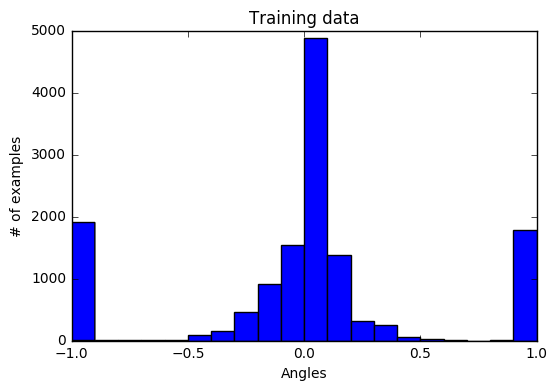

In [4]:
print (max(np.array(y_train)))
print (min(np.array(y_train)))

plt.hist(np.array(y_train), bins=20)
plt.title("Training data")
plt.xlabel("Angles")
plt.ylabel("# of examples")
plt.show()


### Normalize

In [5]:
def normalize(image_data):
    a = -0.5
    b = 0.5
    img_min = 0
    img_max = 255
    return a + ( ( (image_data - img_min)*(b - a) )/( img_max - img_min ) )

# Model

#### VGG with drop out, batch normalition

#### 20 EPOCHS Adam optimizer linear regression

#### Validation


from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Input, Dropout, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

input_tensor = Input(shape=(160, 320, 3))
croped_input_img = Cropping2D(cropping=((60, 20), (0, 0)))(input_tensor)
base_model = VGG16(input_tensor=croped_input_img, weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024)(top_model)
top_model = BatchNormalization()(top_model)
top_model = Activation('relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1)(top_model)
top_model = BatchNormalization()(top_model)
predictions = Activation('tanh')(top_model)

model = Model(input=input_tensor, output=predictions)

In [6]:
from keras.layers import merge, Cropping2D, Convolution2D, MaxPooling2D, Input, Flatten, Dense, Activation
from keras.models import Model

input_img = Input(shape=(160, 320, 3))
croped_input_img = Cropping2D(cropping=((60, 20), (0, 0)))(input_img)

tower_1 = Convolution2D(20, 8, 8, activation='relu')(croped_input_img)
tower_1 = MaxPooling2D((2, 2))(tower_1)
tower_1 = Convolution2D(30, 5, 5, activation='relu')(tower_1)
tower_1 = MaxPooling2D((2, 2))(tower_1)
tower_1 = Convolution2D(40, 5, 5, activation='relu')(tower_1)
tower_1 = MaxPooling2D((2, 2))(tower_1)

tower_1 = Flatten()(tower_1)
tower_1 = Dense(1000)(tower_1)
tower_1 = Activation('relu')(tower_1)

tower_2 = Convolution2D(20, 3, 3, activation='relu')(croped_input_img)
tower_2 = MaxPooling2D((2, 2))(tower_2)
tower_2 = Convolution2D(30, 3, 3, activation='relu')(tower_2)
tower_2 = MaxPooling2D((2, 2))(tower_2)
tower_2 = Convolution2D(40, 3, 3, activation='relu')(tower_2)
tower_2 = MaxPooling2D((2, 2))(tower_2)
tower_2 = Convolution2D(40, 3, 3, activation='relu')(tower_2)
tower_2 = MaxPooling2D((2, 2))(tower_2)

tower_2 = Flatten()(tower_2)
tower_2 = Dense(1000)(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = Dense(1000)(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = Dense(1000)(tower_2)
tower_2 = Activation('relu')(tower_2)

tower_3 = Convolution2D(20, 1, 1, activation='relu')(croped_input_img)
tower_3 = MaxPooling2D((2, 2))(tower_3)
tower_3 = Convolution2D(30, 2, 2, activation='relu')(tower_3)
tower_3 = MaxPooling2D((2, 2))(tower_3)
tower_3 = Convolution2D(30, 1, 1, activation='relu')(tower_3)
tower_3 = MaxPooling2D((2, 2))(tower_3)
tower_3 = Convolution2D(40, 1, 1, activation='relu')(tower_3)
tower_3 = MaxPooling2D((2, 2))(tower_3)
tower_3 = Convolution2D(40, 2, 2, activation='relu')(tower_3)
tower_3 = MaxPooling2D((2, 2))(tower_3)

tower_3 = Flatten()(tower_3)
tower_3 = Dense(1000)(tower_3)
tower_3 = Activation('relu')(tower_3)
tower_3 = Dense(1000)(tower_3)
tower_3 = Activation('relu')(tower_3)
tower_3 = Dense(1000)(tower_3)
tower_3 = Activation('relu')(tower_3)

output = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)

predictions = Dense(1)(output)
predictions = Activation('tanh')(predictions)

model = Model(input=input_img, output=predictions)

Using TensorFlow backend.


In [7]:
def process_line(row, normalize_feature=True):
    b,g,r = cv2.split(cv2.imread(row['path']))
    img = np.array(cv2.merge([r,g,b]))
    
    if normalize_feature:
        img = normalize(img)
        
    steering = float(row['steering'])            
    return [img, steering]

def generate_arrays_from_file(path, batch_size = 20, total=0):
    while 1:
        global X_train
        global y_train
        X_train, y_train = shuffle(X_train, y_train)
        Xs = []
        ys = []        
        for i in range(len(X_train)):
            if (len(Xs) == batch_size):
                yield (np.array(Xs), np.array(ys))
                Xs = []
                ys = []

            x, y = process_line({'path':X_train[i], 'steering':y_train[i]})
            Xs.append(x)
            ys.append(y)

        yield (np.array(Xs), np.array(ys))
            

from keras.layers import Cropping2D
from keras.models import Sequential

model = Sequential()
model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=(160, 320, 3)))
# now model.output_shape == (None, 3, 24, 20)
#model.add(Convolution2D(1, 3, 3, border_mode='same))
#model.add(Cropping2D(cropping=((2, 2), (2, 2))))
# now model.output_shape == (None, 64, 20, 16)
imgs = []
img0, angle0 = process_line({'path':X_train[1000], 'steering':y_train[1000]}, normalize_feature=False)
img1, angle1 = process_line({'path':X_train[1], 'steering':y_train[1]}, normalize_feature=False)
imgs.append(img0)
#imgs.append(img1)

processed_img = model.predict(np.array(imgs))
print(np.shape(processed_img))

plt.imshow(processed_img[0])

                        

In [ ]:
train_rows = len(X_train)
validation_rows = len(X_validation)
    
print('train records: ', train_rows)
print('validation records: ', validation_rows)

train records:  13778
validation records:  1608


In [ ]:
from keras.optimizers import RMSprop
optimizer = RMSprop(lr=0.001)
model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer=optimizer)
history = model.fit_generator(generate_arrays_from_file('train.csv',batch_size=128), samples_per_epoch=train_rows, nb_epoch=10, validation_data=generate_arrays_from_file('validation.csv', batch_size=1),nb_val_samples=validation_rows)

Epoch 1/10
10624/13778 [======================>.......] - ETA: 36s - loss: 1.2635 - acc: 0.1320

In [ ]:
#for layer in model.layers:
#    layer.trainable = True
    
#model.save('model1.h5')
#model_json = model.to_json()
#with open("model1.json", "w") as json_file:
#    json_file.write(model_json)

In [ ]:
#from keras.models import load_model, model_from_json

#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("model.h5")

In [ ]:
#for layer in model.layers:
#    layer.trainable = True

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#model.load_weights("model1.h5")